In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torch.optim as optim
import time
import seaborn as sns
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from medmnist import OCTMNIST
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # Resize to 28x28 if necessary
    transforms.Resize(size=(28, 28), antialias=True),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 32

# Define the dataset
dataset = OCTMNIST(root='./medmnist/', split='train', download=True, transform=transform)

# Calculate sizes for each split
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Using downloaded and verified file: ./medmnist/octmnist.npz


In [5]:
# Dataloaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
# Dataset Info
dataset.info

{'python_class': 'OCTMNIST',
 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/octmnist.npz?download=1',
 'MD5': 'c68d92d5b585d8d81f7112f81e2d0842',
 'url_64': 'https://zenodo.org/records/10519652/files/octmnist_64.npz?download=1',
 'MD5_64': 'e229e9440236b774d9f0dfef9d07bdaf',
 'url_128': 'https://zenodo.org/records/10519652/files/octmnist_128.npz?download=1',
 'MD5_128': '0a97e76651ace45c5d943ee3f65b63ae',
 'url_224': 'https://zenodo.org/records/10519652/files/octmnist_224.npz?downl

In [7]:
# Check image channel if 1, grayscale image if 3, RGB image
for image, label in trainloader:
    if image.shape[1] == 1:
        print("Grayscale image")
    else:
        print("RGB image")
    break

Grayscale image


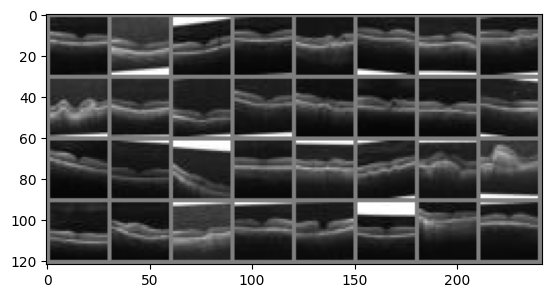

normal normal normal normal choroidal neovascularization normal normal choroidal neovascularization choroidal neovascularization normal diabetic macular edema choroidal neovascularization choroidal neovascularization choroidal neovascularization drusen normal normal normal choroidal neovascularization normal drusen choroidal neovascularization choroidal neovascularization choroidal neovascularization normal diabetic macular edema choroidal neovascularization normal diabetic macular edema normal choroidal neovascularization normal


In [8]:
classes = list(dataset.info['label'].values())

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
class CNN(nn.Module):
    def __init__(self, dropoutAdd=False):
        super().__init__()
        self.dropoutAdd = dropoutAdd
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with p=0.2

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        # Applying dropout after the first fully connected layer
        if self.dropoutAdd:
            x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # Applying dropout after the second fully connected layer
        if self.dropoutAdd:
            x = self.dropout(x)
        x = self.fc3(x)
        return x

In [21]:
# Torchinfo Summary of base model
torchinfoSummary = torchinfo.summary(CNN(dropoutAdd=False), input_data=torch.randn(
    batch_size, 1, 28, 28))  # batch_size=32, channels=1, height=28, width=28
print(torchinfoSummary)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 4]                   --
├─Conv2d: 1-1                            [32, 16, 24, 24]          416
├─MaxPool2d: 1-2                         [32, 16, 12, 12]          --
├─Conv2d: 1-3                            [32, 32, 8, 8]            12,832
├─MaxPool2d: 1-4                         [32, 32, 4, 4]            --
├─Linear: 1-5                            [32, 512]                 262,656
├─Linear: 1-6                            [32, 256]                 131,328
├─Linear: 1-7                            [32, 4]                   1,028
Total params: 408,260
Trainable params: 408,260
Non-trainable params: 0
Total mult-adds (M): 46.59
Input size (MB): 0.10
Forward/backward pass size (MB): 3.08
Params size (MB): 1.63
Estimated Total Size (MB): 4.81


In [23]:
def modelTraining(model, criterion, optimizer, earlyStopping=False):
    import time

    startTime = time.time()

    training_loss_plt_arr = []
    validation_loss_plt_arr = []
    testing_loss_plt_arr = []

    epochs = 5
    max_consecutive = 0
    consecutive_count = 0
    previous_number = float('inf')

    for epoch in range(epochs):
        training_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            labels = labels.flatten()
            loss_training = criterion(outputs, labels)
            loss_training.backward()
            optimizer.step()

            training_loss += loss_training.item()

            if i % 500 == 499:
                validation_loss = 0.0
                with torch.no_grad():
                    for data in valloader:
                        images, labels = data
                        outputs = model(images)
                        labels = labels.flatten()
                        loss_validation = criterion(outputs, labels)
                        validation_loss += loss_validation.item()

                testing_loss = 0.0
                with torch.no_grad():
                    for data in testloader:
                        images, labels = data
                        outputs = model(images)
                        labels = labels.flatten()
                        loss_testing = criterion(outputs, labels)
                        testing_loss += loss_testing.item()

                training_loss = round((training_loss / 500), 3)
                validation_loss = round((validation_loss / len(valloader)), 3)
                testing_loss = round((testing_loss / len(testloader)), 3)

                print(
                    f"[{epoch + 1}, {i + 1}], Training loss: {training_loss}, Validation loss: {validation_loss}, Testing loss: {testing_loss}")

                training_loss_plt_arr.append(training_loss)
                validation_loss_plt_arr.append(validation_loss)
                testing_loss_plt_arr.append(testing_loss)
                training_loss = 0.0

                # Early stopping condition
                if earlyStopping:
                    if validation_loss < previous_number:
                        previous_number = validation_loss
                        consecutive_count = 0
                    else:
                        consecutive_count += 1
                        max_consecutive = max(
                            max_consecutive, consecutive_count)
                        if max_consecutive == 3:
                            print(
                                "\nStopping training as Validation Loss stopped improving.")
                            break

        if earlyStopping:
            if max_consecutive == 3:
                break

    print("Finished Training")

    endTime = time.time()
    time_to_train = (endTime - startTime)

    # Convert total time to minutes and seconds
    minutes = int(time_to_train // 60)
    seconds = int(time_to_train % 60)

    print(f"\nTime to train: {minutes}min {seconds}sec")
    
    return training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr

In [24]:
# Losses visualisation
def LossesPlot(training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr):
    lenLoss = len(training_loss_plt_arr) + 1
    # Plot the loss graph
    plt.plot(range(1, lenLoss), training_loss_plt_arr,
             label='Training Loss', color='red')
    plt.plot(range(1, lenLoss), validation_loss_plt_arr,
             label='Validation Loss', color='green')
    plt.plot(range(1, lenLoss), testing_loss_plt_arr,
             label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation vs Testing loss')
    plt.legend()
    plt.show()

In [26]:
# Updated Performance Evaluation
def loadersAccuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    trueLabels, predictedLabels = [], []
    trueLabelsROC, predictedLabelsROC = [], []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.flatten()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            trueLabels.extend(labels.tolist())
            predictedLabels.extend(predicted.tolist())
            # ROC
            preds = F.softmax(outputs, dim=1)
            trueLabelsROC.extend(labels.tolist())
            predictedLabelsROC.extend(preds.tolist())

    accuracy = (correct / total * 100)
    return accuracy, trueLabels, predictedLabels, trueLabelsROC, predictedLabelsROC

def perfEvaluation(model):
    model.eval()

    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels, test_trueLabelsROC, test_predictedLabelsROC = loadersAccuracy(
        testloader, model)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")

    valid_accuracy, _, _, _, _ = loadersAccuracy(valloader, model)
    train_accuracy, _, _, _, _ = loadersAccuracy(trainloader, model)

    # Convert labels and predicted from list to tensor for metric calucaltions
    test_predictedLabels = torch.tensor(test_predictedLabels)
    test_trueLabels = torch.tensor(test_trueLabels)
    test_trueLabelsROC = torch.tensor(test_trueLabelsROC)
    test_predictedLabelsROC = torch.tensor(test_predictedLabelsROC)

    # Precision, Recall, Fscore
    precision, recall, fscore, _ = precision_recall_fscore_support(
        test_trueLabels, test_predictedLabels, average='weighted')
    print(f"Precision = {precision:.2f}")
    print(f"Recall = {recall:.2f}")
    print(f"Fscore = {fscore:.2f}")

    # Plot the Accuracies
    labels = ['Training', 'Validation', 'Test']
    accuracies = [train_accuracy, valid_accuracy, test_accuracy]
    plt.bar(labels, accuracies, color=['red', 'green', 'blue'])
    plt.xlabel('Splits')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    for i, v in enumerate(accuracies):
        plt.text(i, v + 1, f'{v:.2f}', color='black', ha='center')
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(test_trueLabels, test_predictedLabels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges",
                xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

    # Plot ROC Curve
    metric = MulticlassROC(num_classes=4)
    metric.update(test_predictedLabelsROC, test_trueLabelsROC)
    metric.plot(score=True)

### Base Model

[1, 500], Training loss: 0.91, Validation loss: 0.661, Testing loss: 0.674
[1, 1000], Training loss: 0.608, Validation loss: 0.544, Testing loss: 0.554
[1, 1500], Training loss: 0.557, Validation loss: 0.566, Testing loss: 0.577
[1, 2000], Training loss: 0.507, Validation loss: 0.499, Testing loss: 0.507
[2, 500], Training loss: 0.457, Validation loss: 0.461, Testing loss: 0.471
[2, 1000], Training loss: 0.452, Validation loss: 0.435, Testing loss: 0.443
[2, 1500], Training loss: 0.442, Validation loss: 0.423, Testing loss: 0.43
[2, 2000], Training loss: 0.428, Validation loss: 0.43, Testing loss: 0.438
[3, 500], Training loss: 0.398, Validation loss: 0.394, Testing loss: 0.403
[3, 1000], Training loss: 0.384, Validation loss: 0.398, Testing loss: 0.405
[3, 1500], Training loss: 0.387, Validation loss: 0.385, Testing loss: 0.392
[3, 2000], Training loss: 0.375, Validation loss: 0.385, Testing loss: 0.402
[4, 500], Training loss: 0.347, Validation loss: 0.369, Testing loss: 0.377
[4, 10

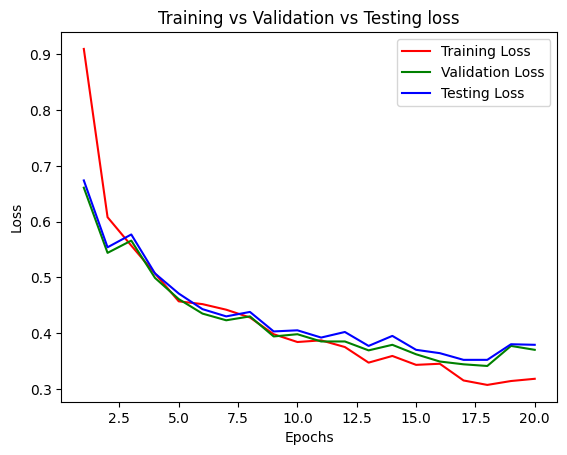

Accuracy on the testing dataset = 87.95
Precision = 0.87
Recall = 0.88
Fscore = 0.87


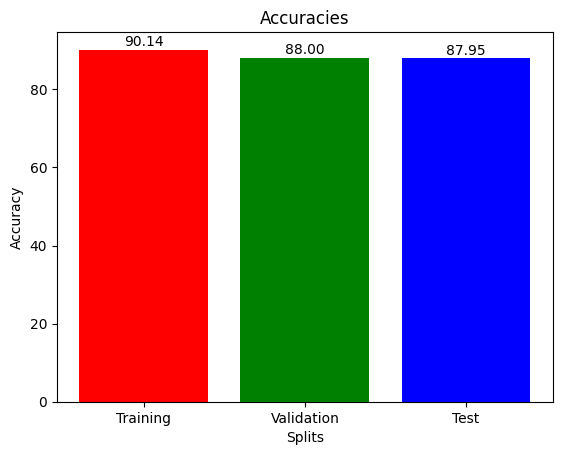

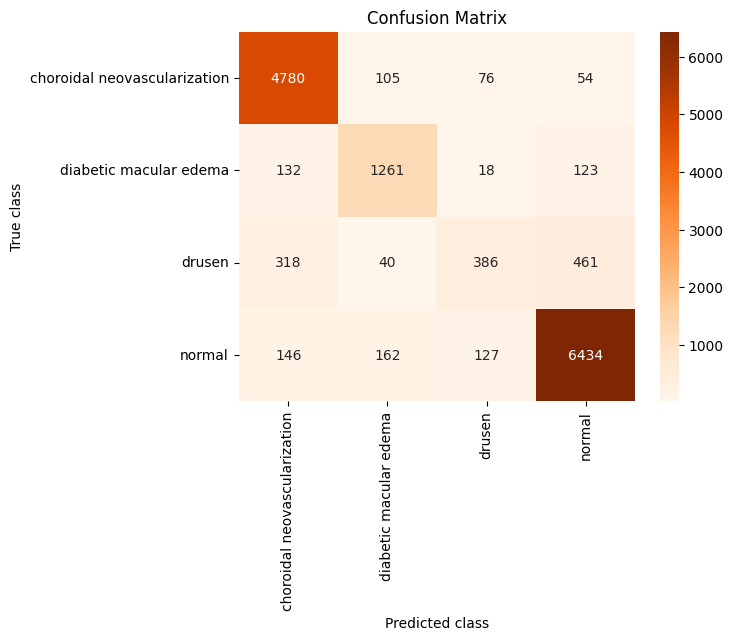

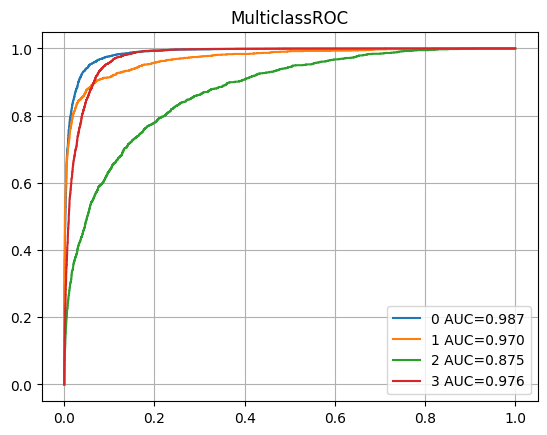

In [27]:
CNN_M1 = CNN(dropoutAdd=False)
criterion_M1 = nn.CrossEntropyLoss()
optimizer_M1 = optim.Adam(CNN_M1.parameters(), lr=0.001)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=CNN_M1, criterion=criterion_M1,
                                                                                     optimizer=optimizer_M1, earlyStopping=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=CNN_M1)

### Model with Regularization

[1, 500], Training loss: 1.013, Validation loss: 0.768, Testing loss: 0.788
[1, 1000], Training loss: 0.735, Validation loss: 0.644, Testing loss: 0.665
[1, 1500], Training loss: 0.641, Validation loss: 0.592, Testing loss: 0.612
[1, 2000], Training loss: 0.592, Validation loss: 0.605, Testing loss: 0.626
[2, 500], Training loss: 0.57, Validation loss: 0.537, Testing loss: 0.55
[2, 1000], Training loss: 0.56, Validation loss: 0.531, Testing loss: 0.544
[2, 1500], Training loss: 0.522, Validation loss: 0.509, Testing loss: 0.522
[2, 2000], Training loss: 0.53, Validation loss: 0.535, Testing loss: 0.548
[3, 500], Training loss: 0.508, Validation loss: 0.492, Testing loss: 0.506
[3, 1000], Training loss: 0.497, Validation loss: 0.508, Testing loss: 0.514
[3, 1500], Training loss: 0.498, Validation loss: 0.484, Testing loss: 0.5
[3, 2000], Training loss: 0.476, Validation loss: 0.48, Testing loss: 0.496
[4, 500], Training loss: 0.455, Validation loss: 0.463, Testing loss: 0.48
[4, 1000], 

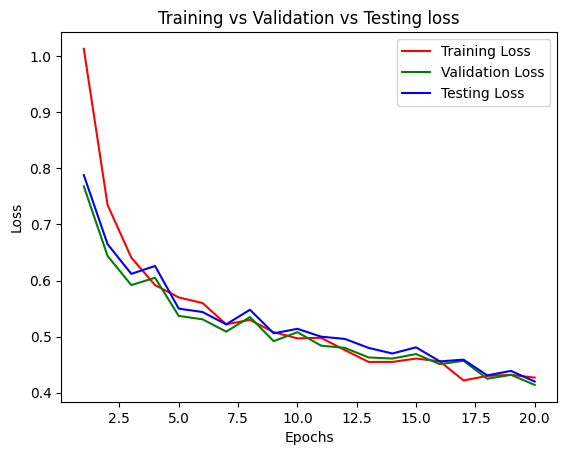

Accuracy on the testing dataset = 85.55
Precision = 0.84
Recall = 0.86
Fscore = 0.84


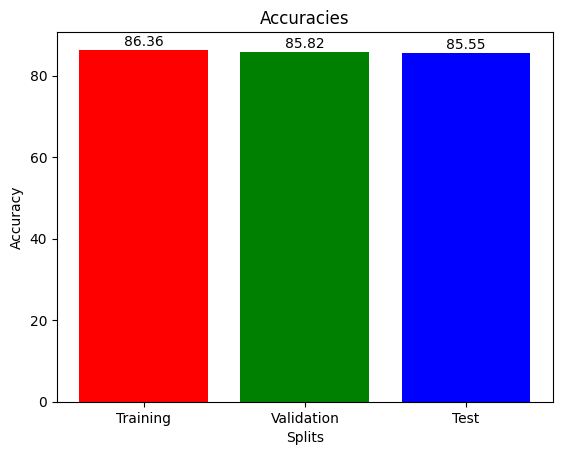

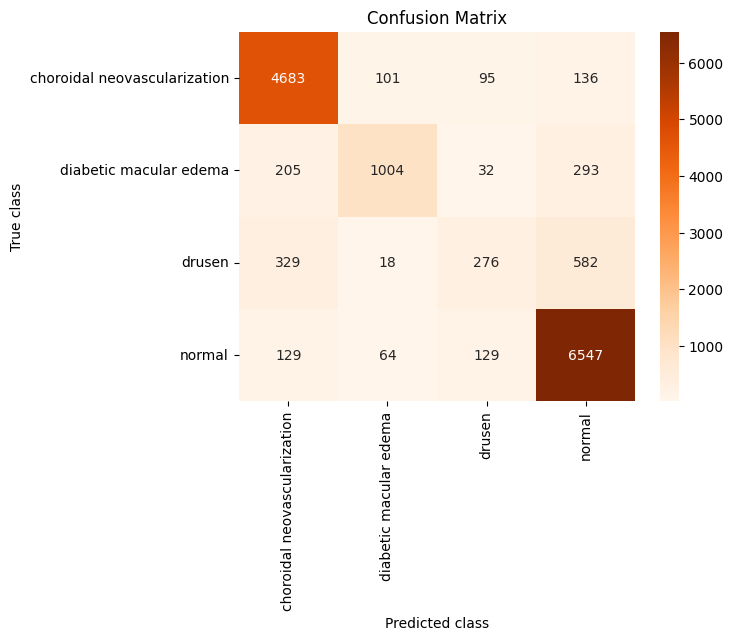

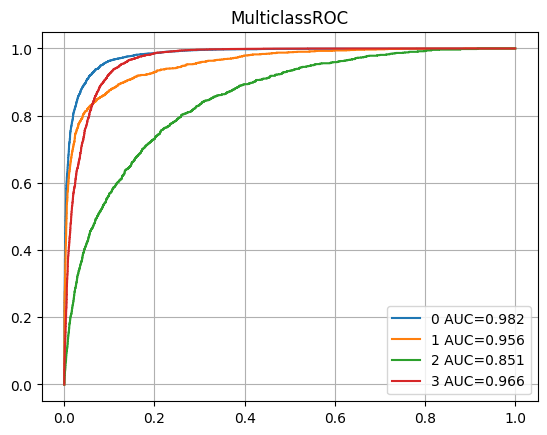

In [28]:
CNN_M2 = CNN(dropoutAdd=False)
# Regularization (L2)
l2_reg = 0.001  # Regularization parameter
criterion_M2 = nn.CrossEntropyLoss()
optimizer_M2 = optim.Adam(CNN_M2.parameters(),
                          lr=0.001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=CNN_M2, criterion=criterion_M2,
                                                                                     optimizer=optimizer_M2, earlyStopping=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=CNN_M2)

### Model with Regularization and Dropout

[1, 500], Training loss: 0.817, Validation loss: 0.758, Testing loss: 0.764
[1, 1000], Training loss: 0.61, Validation loss: 0.541, Testing loss: 0.553
[1, 1500], Training loss: 0.559, Validation loss: 0.518, Testing loss: 0.524
[1, 2000], Training loss: 0.527, Validation loss: 0.503, Testing loss: 0.517
[2, 500], Training loss: 0.486, Validation loss: 0.476, Testing loss: 0.481
[2, 1000], Training loss: 0.481, Validation loss: 0.444, Testing loss: 0.454
[2, 1500], Training loss: 0.461, Validation loss: 0.511, Testing loss: 0.524
[2, 2000], Training loss: 0.453, Validation loss: 0.435, Testing loss: 0.446
[3, 500], Training loss: 0.437, Validation loss: 0.459, Testing loss: 0.459
[3, 1000], Training loss: 0.43, Validation loss: 0.48, Testing loss: 0.489
[3, 1500], Training loss: 0.437, Validation loss: 0.422, Testing loss: 0.429
[3, 2000], Training loss: 0.42, Validation loss: 0.426, Testing loss: 0.43
[4, 500], Training loss: 0.401, Validation loss: 0.408, Testing loss: 0.416
[4, 1000

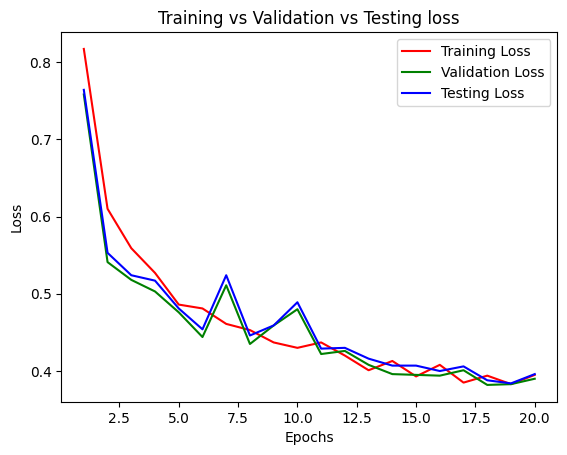

Accuracy on the testing dataset = 86.78
Precision = 0.85
Recall = 0.87
Fscore = 0.85


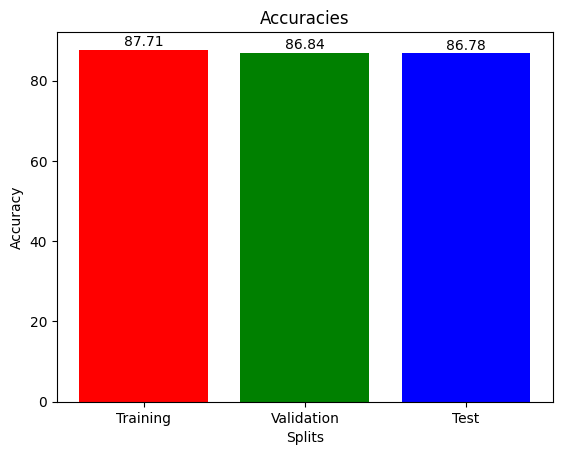

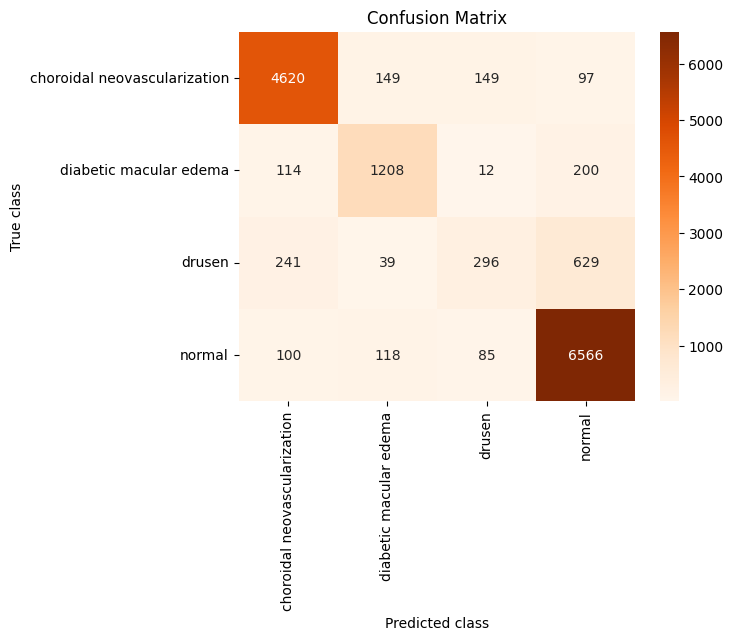

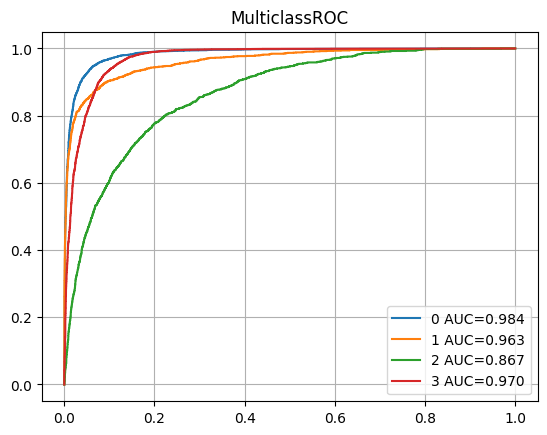

In [29]:
CNN_M3 = CNN(dropoutAdd=True)
# Regularization (L2)
l2_reg = 0.001  # Regularization parameter
criterion_M3 = nn.CrossEntropyLoss()
optimizer_M3 = optim.Adam(CNN_M3.parameters(),
                          lr=0.001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=CNN_M3, criterion=criterion_M3,
                                                                                     optimizer=optimizer_M3, earlyStopping=False)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=CNN_M3)

### Model with Regularization, Dropout and Early Stopping

[1, 500], Training loss: 0.893, Validation loss: 0.745, Testing loss: 0.76
[1, 1000], Training loss: 0.636, Validation loss: 0.581, Testing loss: 0.597
[1, 1500], Training loss: 0.581, Validation loss: 0.567, Testing loss: 0.582
[1, 2000], Training loss: 0.555, Validation loss: 0.514, Testing loss: 0.52
[2, 500], Training loss: 0.513, Validation loss: 0.495, Testing loss: 0.501
[2, 1000], Training loss: 0.509, Validation loss: 0.489, Testing loss: 0.494
[2, 1500], Training loss: 0.492, Validation loss: 0.471, Testing loss: 0.481
[2, 2000], Training loss: 0.484, Validation loss: 0.465, Testing loss: 0.473
[3, 500], Training loss: 0.449, Validation loss: 0.445, Testing loss: 0.45
[3, 1000], Training loss: 0.462, Validation loss: 0.449, Testing loss: 0.447
[3, 1500], Training loss: 0.466, Validation loss: 0.447, Testing loss: 0.447
[3, 2000], Training loss: 0.47, Validation loss: 0.462, Testing loss: 0.461

Stopping training as Validation Loss stopped improving.
Finished Training

Time to

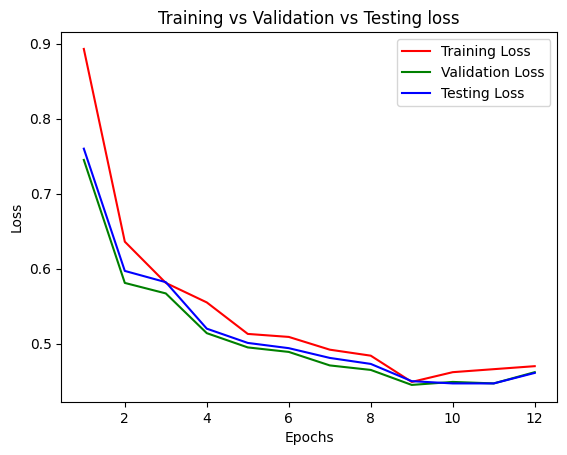

Accuracy on the testing dataset = 84.23
Precision = 0.82
Recall = 0.84
Fscore = 0.81


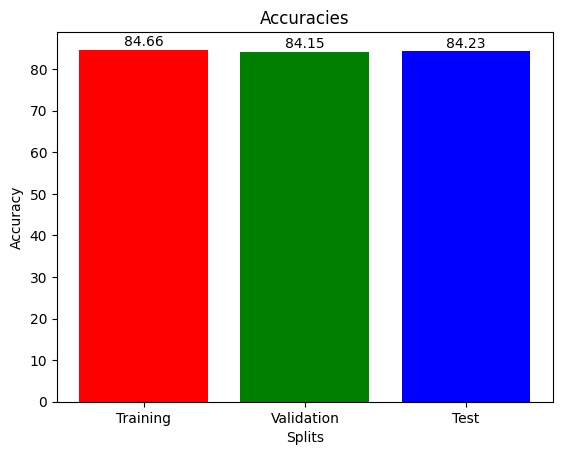

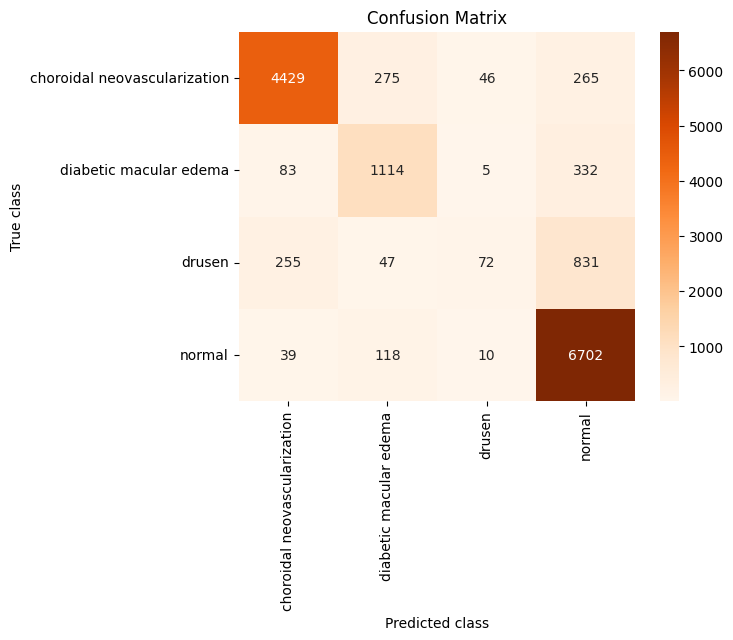

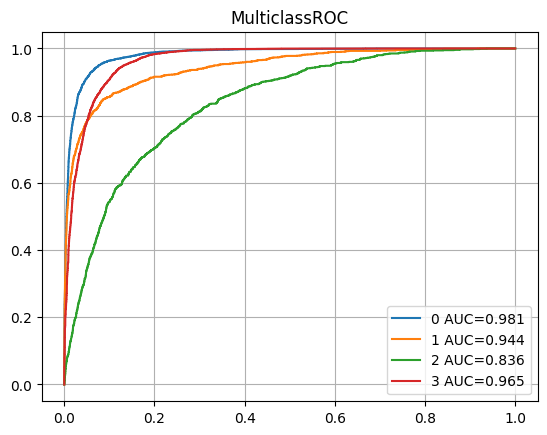

In [30]:
CNN_M4 = CNN(dropoutAdd=True)
# Regularization (L2)
l2_reg = 0.001  # Regularization parameter
criterion_M4 = nn.CrossEntropyLoss()
optimizer_M4 = optim.Adam(CNN_M4.parameters(),
                          lr=0.001, weight_decay=l2_reg)
training_loss_plt_arr, validation_loss_plt_arr, testing_loss_plt_arr = modelTraining(model=CNN_M4, criterion=criterion_M4,
                                                                                     optimizer=optimizer_M4, earlyStopping=True)
LossesPlot(training_loss_plt_arr,
           validation_loss_plt_arr, testing_loss_plt_arr)
perfEvaluation(model=CNN_M4)

### Best model weights

In [31]:
# Save model weights with best accuracy
torch.save(CNN_M1.state_dict(), 'ngupta22_assignment0_part_3.pt')

# References

1. https://pandas.pydata.org/docs/
1. https://numpy.org/doc/
1. https://matplotlib.org/stable/index.html
1. https://scikit-learn.org/stable/
1. https://seaborn.pydata.org/
1. https://pytorch.org/tutorials/
1. https://github.com/MedMNIST/MedMNIST/
1. https://lightning.ai/docs/torchmetrics/stable/
1. https://numpy.org/doc/stable/
1. https://flask.palletsprojects.com/en/3.0.x/
1. Part 3, Steps 3 and 5 is based on CSE 574 Machine Learning Assignment 2 Part 3 submission by Nikhil Gupta